# ***Libraries***

In [29]:
import math
import os
import sys
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

In [12]:
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length, plotFig, printResult

from TSB_UAD.models.iforest import IForest

## ***Data Pre-Processing***

In [13]:
# Load the data for the evaluation.
all_data = []

with open('dataset.pkl', 'rb') as f:
    data = pkl.load(f)

all_data.extend(data['evaluation']['single_normality'])
all_data.extend(data['evaluation']['double_normality'])
all_data.extend(data['evaluation']['triple_normality'])
all_data.extend(data['evaluation']['quadruple_normality'])

In [14]:
preprocessed_dict = {}

In [15]:
# Set the number of windows to be fit per batch.

for timeseries in all_data:
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised method
    name = timeseries['Name']

    data = timeseries['data']
    max_length = data.shape[0]
    label = timeseries['labels']

    slidingWindow = find_length(data) * 2
    X_data = Window(window=slidingWindow).convert(data).to_numpy()

    print(f'Time-Series name: {name}')
    print("Estimated Subsequence length: ", slidingWindow)
    print()
    
    # Store the pre-processed variables in the new dictionary
    preprocessed_dict[name] = {
        'name': name,
        'data': data,
        'label': label,
        'slidingWindow': slidingWindow,
        'X_data': X_data,
        'Time series length': len(data),
        'Number of abnormal points': list(label).count(1)
    }

Time-Series name: ECG1
Estimated Subsequence length:  294

Time-Series name: IOPS1
Estimated Subsequence length:  576

Time-Series name: Genesis1
Estimated Subsequence length:  250

Time-Series name: Occupancy1
Estimated Subsequence length:  250

Time-Series name: ECG1+IOPS1
Estimated Subsequence length:  294

Time-Series name: Genesis1+Occupancy1
Estimated Subsequence length:  250

Time-Series name: ECG1+IOPS1+Occupancy1
Estimated Subsequence length:  294

Time-Series name: Genesis1+ECG1+Occupancy1
Estimated Subsequence length:  294

Time-Series name: ECG1+IOPS1+Genesis1+Occupancy1
Estimated Subsequence length:  294



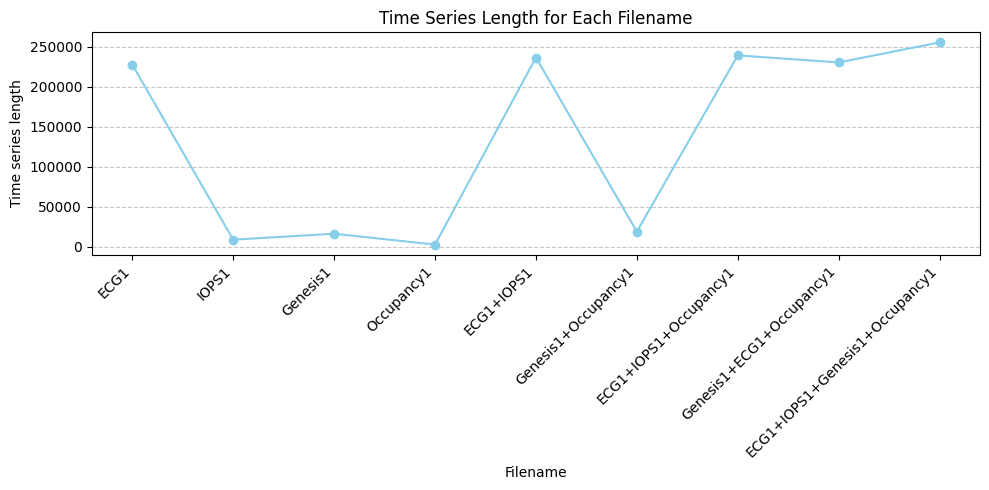

In [16]:
# Get filenames, time series lengths, and number of abnormal points
filenames = list(preprocessed_dict.keys())
time_series_lengths = [data['Time series length'] for data in preprocessed_dict.values()]
number_of_abnormal_points = [data['Number of abnormal points'] for data in preprocessed_dict.values()]

# Plot 'Time series length' and 'Number of abnormal points' for each filename
plt.figure(figsize=(10, 5))
plt.plot(filenames, time_series_lengths, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Filename')
plt.ylabel('Time series length')
plt.title('Time Series Length for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

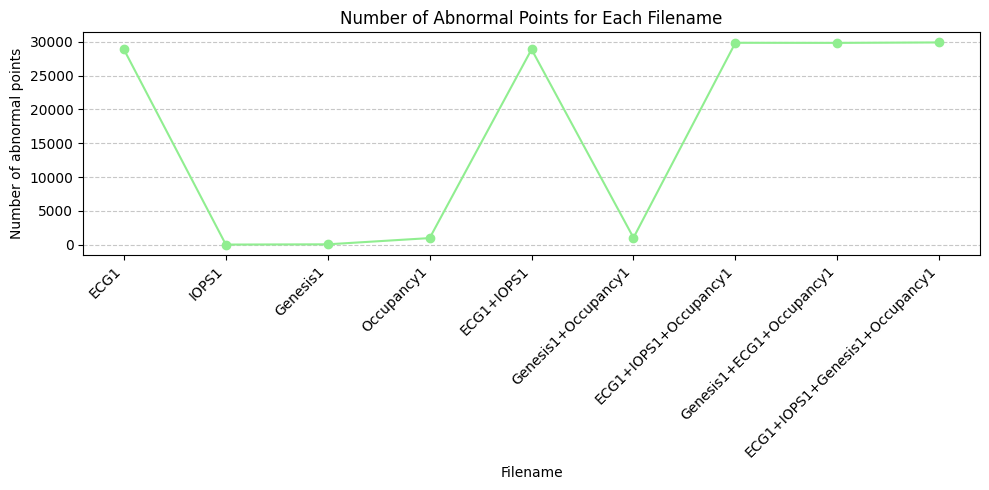

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(filenames, number_of_abnormal_points, marker='o', linestyle='-', color='lightgreen')
plt.xlabel('Filename')
plt.ylabel('Number of abnormal points')
plt.title('Number of Abnormal Points for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## ***Anomaly Detection***

### ***Isolation Forest***

In [19]:
from tqdm.notebook import tqdm_notebook as tqdm

modelName = 'IForest'
clf = IForest(n_jobs=10)

In [21]:
results = []

for name in (p := tqdm(preprocessed_dict.keys())):
    p.set_description(name)
    ts = preprocessed_dict[name]
    x = ts['X_data']
    
    score = []
    clf.fit(x)
    score = clf.decision_scores_
    
    score = np.array(score)
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    score = np.array([score[0]]*math.ceil((ts['slidingWindow']-1)/2) + list(score) + [score[-1]]*((ts['slidingWindow']-1)//2))
    
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    results.append([name] + L)

  0%|          | 0/9 [00:00<?, ?it/s]

In [24]:
columns = ['Name'] + ['AUC', 'Precision', 'Recall', 'F-score', 'Range-recall', 'ExistenceReward', 'OverlapReward', 'Range-precision', 'Range-Fscore', 'Precision@k', 'RangeAUC']
df = pd.DataFrame(results, columns=columns)

In [26]:
df['Number of anomalies'] = df['Name'].apply(lambda x: np.sum(preprocessed_dict[x]['label']))
df[['Name', 'AUC', 'Precision@k', 'Number of anomalies']]

,Name,AUC,Precision@k,Number of anomalies
0,ECG1,0.824531,0.026874,28875.0
1,IOPS1,0.549328,0.000000,13.0
2,Genesis1,0.914464,0.000000,50.0
3,Occupancy1,0.965946,0.000000,972.0
4,ECG1+IOPS1,0.831343,0.025789,28888.0
5,Genesis1+Occupancy1,0.084898,0.000000,1022.0
6,ECG1+IOPS1+Occupancy1,0.826427,0.032552,29860.0
7,Genesis1+ECG1+Occupancy1,0.820067,0.033906,29847.0
8,ECG1+IOPS1+Genesis1+Occupancy1,0.728094,0.001672,29910.0


In [32]:
df.to_csv('Results/Static/IsolationForest-results.csv', index=False)

### ***STUMP***

In [33]:
import stumpy
modelName = 'STUMP'

In [34]:
results = []

results = []

for name in (p := tqdm(preprocessed_dict.keys())):
    p.set_description(name)
    ts = preprocessed_dict[name]
    window_size = ts['slidingWindow']
    x = ts['data']
    
    k = 1
    score_ = stumpy.stump(T_A=x, m=window_size, k=k, ignore_trivial=True, normalize=True)
    score = score_.T[k-1]
    
    score = np.array(score)
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    score = np.array([score[0]]*math.ceil((ts['slidingWindow']-1)/2) + list(score) + [score[-1]]*((ts['slidingWindow']-1)//2))
    
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    results.append([name] + L)

ECG1+IOPS1+Genesis1+Occupancy1: 100%|██████████| 9/9 [04:44<00:00, 31.59s/it]


In [35]:
columns = ['Name'] + ['AUC', 'Precision', 'Recall', 'F-score', 'Range-recall', 'ExistenceReward', 'OverlapReward', 'Range-precision', 'Range-Fscore', 'Precision@k', 'RangeAUC']
df = pd.DataFrame(results, columns=columns)

In [36]:
df['Number of anomalies'] = df['Name'].apply(lambda x: np.sum(preprocessed_dict[x]['label']))
df[['Name', 'AUC', 'Precision@k', 'Number of anomalies']]

,Name,AUC,Precision@k,Number of anomalies
0,ECG1,0.586888,0.035325,28875.0
1,IOPS1,0.641230,0.000000,13.0
2,Genesis1,0.061813,0.000000,50.0
3,Occupancy1,0.338882,0.047325,972.0
4,ECG1+IOPS1,0.603662,0.034028,28888.0
5,Genesis1+Occupancy1,0.093880,0.000000,1022.0
6,ECG1+IOPS1+Occupancy1,0.596124,0.034159,29860.0
7,Genesis1+ECG1+Occupancy1,0.579986,0.036687,29847.0
8,ECG1+IOPS1+Genesis1+Occupancy1,0.554641,0.004246,29910.0


In [37]:
df.to_csv('Results/Static/STUMP-results.csv', index=False)

In [38]:
results = []

results = []

for name in (p := tqdm(preprocessed_dict.keys())):
    p.set_description(name)
    ts = preprocessed_dict[name]
    window_size = ts['slidingWindow']
    x = ts['data']
    
    k = 1
    score_ = stumpy.stump(T_A=x, m=window_size, k=k, ignore_trivial=True, normalize=False)
    score = score_.T[k-1]
    
    score = np.array(score)
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    score = np.array([score[0]]*math.ceil((ts['slidingWindow']-1)/2) + list(score) + [score[-1]]*((ts['slidingWindow']-1)//2))
    
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    results.append([name] + L)

ECG1+IOPS1+Genesis1+Occupancy1: 100%|██████████| 9/9 [12:58<00:00, 86.54s/it] 


In [39]:
columns = ['Name'] + ['AUC', 'Precision', 'Recall', 'F-score', 'Range-recall', 'ExistenceReward', 'OverlapReward', 'Range-precision', 'Range-Fscore', 'Precision@k', 'RangeAUC']
df = pd.DataFrame(results, columns=columns)

In [40]:
df['Number of anomalies'] = df['Name'].apply(lambda x: np.sum(preprocessed_dict[x]['label']))
df[['Name', 'AUC', 'Precision@k', 'Number of anomalies']]

,Name,AUC,Precision@k,Number of anomalies
0,ECG1,0.799097,0.042771,28875.0
1,IOPS1,0.394938,0.000000,13.0
2,Genesis1,0.765657,0.000000,50.0
3,Occupancy1,0.958167,0.123457,972.0
4,ECG1+IOPS1,0.807320,0.038597,28888.0
5,Genesis1+Occupancy1,0.125521,0.000000,1022.0
6,ECG1+IOPS1+Occupancy1,0.811928,0.004923,29860.0
7,Genesis1+ECG1+Occupancy1,0.804775,0.006265,29847.0
8,ECG1+IOPS1+Genesis1+Occupancy1,0.754150,0.001672,29910.0
